In [2]:
import ee
import geemap
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta



In [3]:
# Initialiser Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-baptistebarraque')

In [4]:
# Définir la zone d'intérêt (rectangle)
# Coordonnées des coins du rectangle (longitude, latitude) 
#Zone entre Perpignan, Carcassonne, Toulouse et Andore la ville
coords = [
    [2.9006, 42.6875],
    [2.3539, 43.2163],
    [1.4428, 43.6048],
    [1.5218, 42.5063],
    [2.9006, 42.6875]  # Fermer le polygone
]
roi = ee.Geometry.Polygon(coords)

# Définir la période
start_date = '2023-01-01'
end_date = '2023-12-31'
centroid=roi.centroid().coordinates().getInfo()


In [ ]:
##Cette case n'est pas utilisée ###

# Charger les collections
temperature = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
    .filterDate(start_date, end_date) \
    .select('soil_temperature_level_1')

precipitation = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
    .filterDate(start_date, end_date) \
    .select('total_precipitation_max')

vegetation = ee.ImageCollection('MODIS/061/MOD13A1') \
    .filterDate(start_date, end_date) \
    .select('NDVI')

LAI_HIGH = ee.ImageCollection('MODIS/061/MOD15A2H') \
    .filterDate(start_date, end_date) \
    .select('Lai_500m')

# ALBEDO = ee.ImageCollection('MODIS/006/MCD43A3') \
#     .filterDate(start_date, end_date) \
#     .select('Albedo_BSA_shortwave')

HUMIDITY = ee.ImageCollection('NASA/GLDAS/V022/CLSM/G025/DA1D').filterDate(start_date, end_date).select('AvgSurfT_tavg')


In [6]:
collection_daily_aggr=ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
collection_modis=ee.ImageCollection('MODIS/061/MOD13A1')
collection_humidity=ee.ImageCollection('NASA/GLDAS/V022/CLSM/G025/DA1D')

In [ ]:
# Case de test

date=ee.Date('2005-01-01')
point_geom=ee.Geometry.Point(centroid)
precip=precipitation = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(date, date.advance(1, 'day')).select('total_precipitation_sum').mean() \

print(precip.reduceRegion(
             reducer=ee.Reducer.mean(),
             geometry=point_geom,
             scale=500
         ).get("total_precipitation_sum").getInfo())

0.000320738553909905


In [ ]:
### Fonction non utilisée ###

def get_last_available_value(dataset, point_geom, band, default=None):
    """ Récupère la dernière valeur disponible pour un point donné et une bande spécifique """
    try:
        last_value = dataset.sort('system:time_start', False) \
            .filterBounds(point_geom) \
            .limit(1) \
            .select(band) \
            .mean() \
            .reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point_geom,
                scale=1000
            ).get(band).getInfo()
        return last_value
    except Exception:
        return default  # Retourne une valeur par défaut si aucune donnée n'est trouvée

In [ ]:
### Fonction non-utilisée


def get_average_value_around_point(dataset, point_geom, band, radius_km=5, default=None):
    """
    Récupère la moyenne des valeurs d'un paramètre dans un rayon donné autour d'un point.
    
    :param dataset: Collection Earth Engine
    :param point_geom: Point central (ee.Geometry.Point)
    :param band: Nom de la bande à récupérer
    :param radius_km: Rayon en km autour du point
    :param default: Valeur par défaut si aucune donnée disponible
    :return: Moyenne des valeurs dans la zone ou la dernière valeur connue
    """
    try:
        buffer_zone = point_geom.buffer(radius_km * 1000)  # Création de la zone buffer (mètres)
        mean_value = dataset.filterBounds(buffer_zone) \
            .select(band) \
            .mean() \
            .reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=buffer_zone,
                scale=1000
            ).get(band).getInfo()
        
        if mean_value is None:  # Vérifie si aucune valeur valide n'a été trouvée
            raise ValueError("No data found in buffer zone")
        
        return mean_value

    except Exception:
        return get_last_available_value(dataset, point_geom, band, default)


In [10]:
#Deuxième version de la fonction extract_data avec d'autres bases de données pour certains paramètres

def extract_data(date, point):
    date = ee.Date(date)
    lon, lat = point
    point_geom = ee.Geometry.Point([lon, lat])

    # Sélectionnez la bande appropriée pour la température
    temp = collection_daily_aggr \
        .filterDate(date, date.advance(1, 'day')) \
        .select('soil_temperature_level_1') \
        .mean()

    # Sélectionnez la bande appropriée pour la précipitation
    precip = collection_daily_aggr \
        .filterDate(date, date.advance(1, 'day')) \
        .select('total_precipitation_max') \
        .mean()

    # Sélectionnez la bande appropriée pour le NDVI
    ndvi = collection_modis \
        .filterDate(date, date.advance(1, 'month')) \
        .select('NDVI') \
        .mean()

    # Sélectionnez la bande appropriée pour le LAI
 

    lai_high = collection_daily_aggr.filterDate(date, date.advance(1, 'week')) \
        .select('leaf_area_index_high_vegetation_max') \
        .mean()

    lai_low= collection_daily_aggr.filterDate(date, date.advance(1, 'week')) \
        .select('leaf_area_index_low_vegetation_max') \
        .mean()



    # Sélectionnez la bande appropriée pour l'albédo
    albedo = collection_daily_aggr.filterDate(date, date.advance(1, 'week')) \
            .select('forecast_albedo_max') \
            .mean()
    


    humidity=collection_humidity.filterDate(date, date.advance(1, 'week')).select('SoilMoist_S_tavg').mean()
    

    values = {
        'date': date.format('YYYY-MM-dd').getInfo(),
        'longitude': lon,
        'latitude': lat,
        
        'temperature': temp.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point_geom,
            scale=1000
        ).get('soil_temperature_level_1').getInfo(),
        'precipitation': precip.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point_geom,
            scale=1000
        ).get('total_precipitation_max').getInfo(),
        'ndvi': ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point_geom,
            scale=1000
        ).get('NDVI').getInfo(),
        'lai_high': lai_high.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point_geom,
            scale=5000
        ).get('leaf_area_index_high_vegetation_max').getInfo(),
        'lai_low': lai_low.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point_geom,
            scale=5000
        ).get('leaf_area_index_low_vegetation_max').getInfo(),
        'albedo': albedo.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point_geom,
            scale=5000
        ).get('forecast_albedo_max').getInfo(),
        'humidity':humidity.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point_geom,
            scale=5000
        ).get('SoilMoist_S_tavg').getInfo(),

    }

    return values



In [11]:
extract_data('2023-01-04',(7, 48.8566))

{'date': '2023-01-04',
 'longitude': 7,
 'latitude': 48.8566,
 'temperature': 280.94485092163086,
 'precipitation': 0.0007568016648242804,
 'ndvi': 4692,
 'lai_high': 3.8059605189732144,
 'lai_low': 1.5921630859375,
 'albedo': 0.14088480600288936,
 'humidity': 6.240880966186523}

In [ ]:
### Fonction qui n'est plus utilisée


def is_rainfall_event(date, point, precipitation_threshold=10):
    """
    Détermine si une date donnée correspond à un épisode pluvieux.

    :param date: Date à vérifier (format 'YYYY-MM-DD').
    :param point: Coordonnées (longitude, latitude) du point d'intérêt.
    :param precipitation_threshold: Seuil de précipitation pour définir un épisode pluvieux (en mm).
    :return: True si c'est un épisode pluvieux, False sinon.
    """
    date = ee.Date(date)
    lon, lat = point
    point_geom = ee.Geometry.Point([lon, lat])

    # Charger les données de précipitation pour la date spécifiée
    precipitation = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterDate(date, date.advance(1, 'day')) \
        .select('total_precipitation_max')

    # Calculer la précipitation moyenne pour le point donné
    precip_mean = precipitation.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point_geom,
        scale=1000
    ).get('total_precipitation_max').getInfo()

    # Vérifier si la précipitation dépasse le seuil
    if precip_mean is not None and precip_mean >= precipitation_threshold:
        return True
    return False

In [28]:
import ee
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def get_daily_precipitation(start_date, end_date, point):
    """
    Renvoie un dictionnaire avec les dates comme clés et les niveaux de précipitation comme valeurs pour une région d'intérêt.

    :param start_date: Date de début (format 'YYYY-MM-DD').
    :param end_date: Date de fin (format 'YYYY-MM-DD').
    :param roi: Géométrie de la région d'intérêt (ee.Geometry).
    :return: Dictionnaire avec les dates comme clés et les niveaux de précipitation comme valeurs.
    """
    start_date = ee.Date(start_date)
    end_date = ee.Date(end_date)
    lon, lat = point
    point_geom = ee.Geometry.Point([lon, lat])

    # Charger les données de précipitation pour la période spécifiée
    precipitation_collection = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterDate(start_date, end_date) \
        .select('total_precipitation_max')

    # Dictionnaire pour stocker les dates et les niveaux de précipitation
    daily_precipitation = {}

    # Fonction pour calculer la précipitation moyenne pour une image
    def calculate_precipitation(image):
        date = image.date().format('YYYY-MM-dd').getInfo()
        precip_mean = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point_geom,
            scale=1000
        ).get('total_precipitation_max').getInfo()
        return date, precip_mean

    # Utiliser ThreadPoolExecutor pour paralléliser les appels à getInfo()
    date_range = precipitation_collection.toList(precipitation_collection.size().getInfo())
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(calculate_precipitation, ee.Image(date_range.get(i)))
                   for i in range(date_range.size().getInfo())]

        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing days"):
            date, precip_mean = future.result()
            daily_precipitation[date] = precip_mean if precip_mean is not None else 0

    return daily_precipitation


In [30]:
daily_precipitations=get_daily_precipitation(start_date, end_date, centroid)
print(daily_precipitations)

Processing days: 100%|██████████| 364/364 [00:35<00:00, 10.21it/s]

{'2023-01-01': 8.52346317969932e-07, '2023-01-02': 0.00042147934436798096, '2023-01-06': 3.874301910400391e-06, '2023-01-05': 3.260672082205929e-05, '2023-01-07': 8.583068797918258e-07, '2023-01-04': 1.430511474609375e-06, '2023-01-14': 4.567205905914307e-06, '2023-01-16': 0.0007078879311848141, '2023-01-03': 0.00032547861337661743, '2023-01-08': 0.00102996826171875, '2023-01-12': 0, '2023-01-10': 3.331899642944336e-05, '2023-01-09': 0.0007187426090240479, '2023-01-15': 0.0012422576546669006, '2023-01-11': 0.0005154982209205627, '2023-01-17': 0.0010475963354110718, '2023-01-13': 0.00028874278058310665, '2023-01-18': 0.0004909932613372803, '2023-01-25': 8.809566497802734e-05, '2023-01-23': 0.0001085624098777771, '2023-01-20': 0.0015483640536899657, '2023-01-26': 0.0001308917999267578, '2023-01-29': 5.11854887008667e-05, '2023-01-21': 0.0010282397270202637, '2023-01-19': 0.002363055944442749, '2023-01-22': 0.00017845630645751953, '2023-01-27': 0.0003247439860274426, '2023-01-24': 7.18459

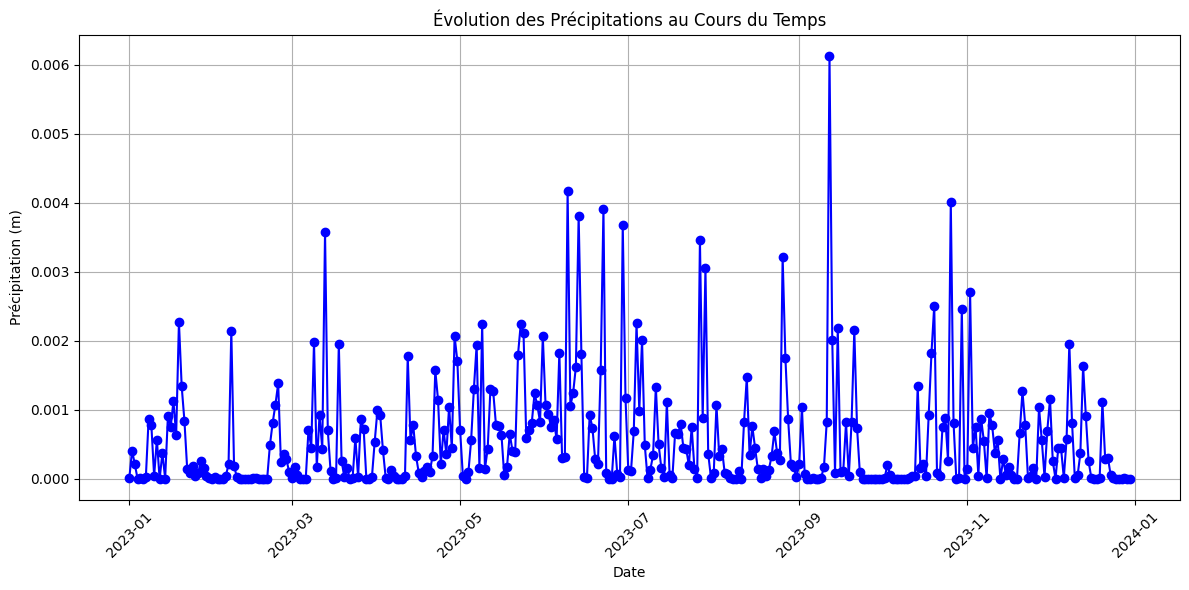

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_precipitation_over_time(daily_precipitation):
    """
    Trace l'évolution des précipitations au cours du temps à partir d'un dictionnaire de précipitations quotidiennes.

    :param daily_precipitation: Dictionnaire avec les dates comme clés et les niveaux de précipitation comme valeurs.
    """
    # Convertir le dictionnaire en DataFrame
    df = pd.DataFrame(list(daily_precipitation.items()), columns=['Date', 'Precipitation'])
    df['Date'] = pd.to_datetime(df['Date'])

    # Trier le DataFrame par date
    df = df.sort_values(by='Date')

    # Tracer l'évolution des précipitations
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Precipitation'], marker='o', linestyle='-', color='b')
    plt.title('Évolution des Précipitations au Cours du Temps')
    plt.xlabel('Date')
    plt.ylabel('Précipitation (m)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_precipitation_over_time(daily_precipitations)

In [16]:
def identify_rainfall_episodes(daily_precipitation, precipitation_threshold=1e-3, secondary_threshold=5e-4):
    """
    Identifie les épisodes pluvieux, leur durée et le total des précipitations à partir d'un dictionnaire de précipitations quotidiennes.

    :param daily_precipitation: Dictionnaire avec les dates comme clés et les niveaux de précipitation comme valeurs.
    :param precipitation_threshold: Seuil de précipitation pour définir un jour pluvieux (en mm).
    :param secondary_threshold: Seuil secondaire pour prolonger un épisode pluvieux (en mm).
    :return: Dictionnaire avec les dates de début des épisodes pluvieux, leur durée et le total des précipitations.
    """
    # Liste pour stocker les dates de début des épisodes pluvieux, leur durée et le total des précipitations
    rainfall_episodes = {}
    current_episode_start = None
    current_episode_duration = 0
    current_episode_total_precip = 0

    # Analyser les résultats pour identifier les épisodes pluvieux
    for date, precip_mean in sorted(daily_precipitation.items()):
        # Vérifier si la précipitation dépasse le seuil principal
        if precip_mean is not None and precip_mean >= precipitation_threshold:
            if current_episode_start is None:
                current_episode_start = date
            current_episode_duration += 1
            current_episode_total_precip += precip_mean
        # Vérifier si la précipitation est entre le seuil principal et le seuil secondaire
        elif precip_mean is not None and precip_mean >= secondary_threshold:
            if current_episode_start is not None:
                current_episode_duration += 1
                current_episode_total_precip += precip_mean
        else:
            if current_episode_start is not None:
                rainfall_episodes[current_episode_start] = {
                    'duration': current_episode_duration,
                    'total_precipitation': current_episode_total_precip
                }
                current_episode_start = None
                current_episode_duration = 0
                current_episode_total_precip = 0

    # Ajouter le dernier épisode s'il est encore en cours
    if current_episode_start is not None:
        rainfall_episodes[current_episode_start] = {
            'duration': current_episode_duration,
            'total_precipitation': current_episode_total_precip
        }

    return rainfall_episodes


In [17]:
rainfall_episodes=identify_rainfall_episodes(daily_precipitations)
print(rainfall_episodes)

{'2023-01-17': {'duration': 5, 'total_precipitation': 0.006217564362049131}, '2023-02-07': {'duration': 1, 'total_precipitation': 0.002146566848394031}, '2023-02-23': {'duration': 2, 'total_precipitation': 0.0024594002507349125}, '2023-03-09': {'duration': 1, 'total_precipitation': 0.0019852836539769893}, '2023-03-13': {'duration': 2, 'total_precipitation': 0.004286797013421389}, '2023-03-18': {'duration': 1, 'total_precipitation': 0.0019620554006755113}, '2023-04-12': {'duration': 3, 'total_precipitation': 0.0031241887025936616}, '2023-04-22': {'duration': 2, 'total_precipitation': 0.0027167418403598893}, '2023-04-27': {'duration': 1, 'total_precipitation': 0.0010469675382219989}, '2023-04-29': {'duration': 3, 'total_precipitation': 0.00448492741914523}, '2023-05-06': {'duration': 2, 'total_precipitation': 0.0032523548625733156}, '2023-05-09': {'duration': 1, 'total_precipitation': 0.0022418049296323494}, '2023-05-12': {'duration': 5, 'total_precipitation': 0.004773784212333299}, '202

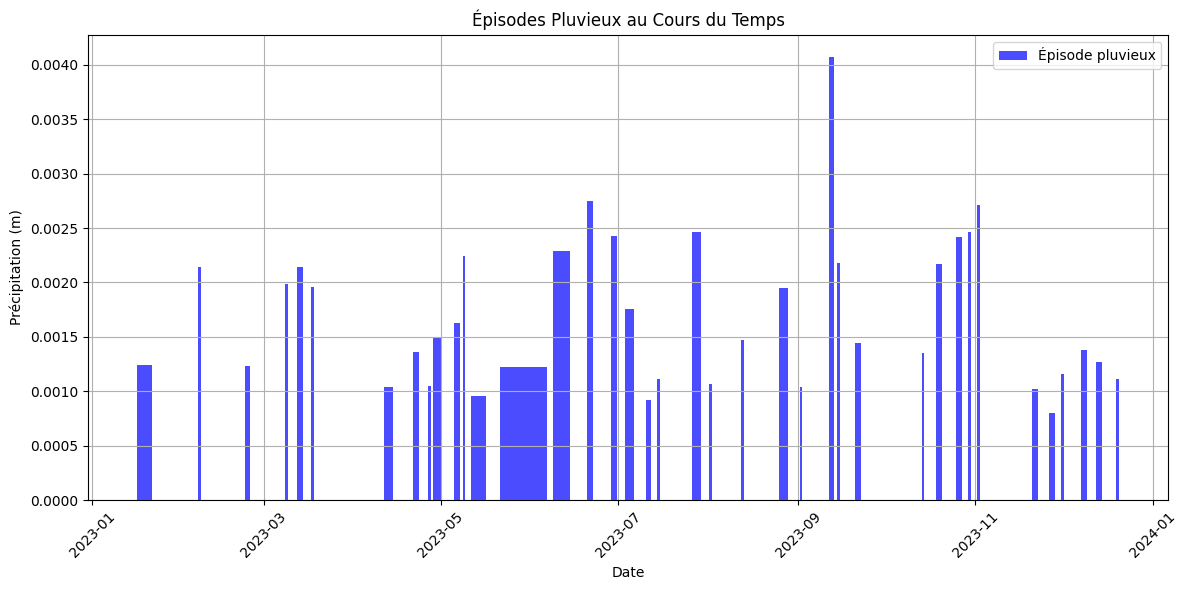

In [18]:
def plot_rainfall_episodes(rainfall_episodes):
    """
    Trace les épisodes pluvieux sur une ligne de temps.

    :param rainfall_episodes: Dictionnaire avec les dates de début des épisodes pluvieux, leur durée et le total des précipitations.
    """
    # Convertir le dictionnaire en DataFrame pour faciliter le traçage
    data = []
    for start_date, episode_info in rainfall_episodes.items():
        duration = episode_info['duration']
        total_precip = episode_info['total_precipitation']
        for day in range(duration):
            data.append({
                'Date': pd.to_datetime(start_date) + pd.Timedelta(days=day),
                'Precipitation': total_precip / duration  # Répartir la précipitation uniformément sur la durée
            })

    df = pd.DataFrame(data)

    # Tracer les épisodes pluvieux
    plt.figure(figsize=(12, 6))
    plt.bar(df['Date'], df['Precipitation'], width=1, color='blue', alpha=0.7, label='Épisode pluvieux')
    plt.title('Épisodes Pluvieux au Cours du Temps')
    plt.xlabel('Date')
    plt.ylabel('Précipitation (m)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


plot_rainfall_episodes(rainfall_episodes)


In [19]:

trois_premieres_cles = list(rainfall_episodes.keys())[:3]
truncated_rainfall_episodes = {key: rainfall_episodes[key] for key in trois_premieres_cles}
print(truncated_rainfall_episodes)

{'2023-01-17': {'duration': 5, 'total_precipitation': 0.006217564362049131}, '2023-02-07': {'duration': 1, 'total_precipitation': 0.002146566848394031}, '2023-02-23': {'duration': 2, 'total_precipitation': 0.0024594002507349125}}


In [20]:
def analyze_rainfall_episodes_parallel(start, rainfall_episodes, centroid):
    data_dict = {}
    i = 1
    
    with ThreadPoolExecutor() as executor:
        future_to_date = {}

        for date_str, episode in rainfall_episodes.items():
            index=start[:4]+'_'+str(i)
            start_date = datetime.strptime(date_str, '%Y-%m-%d')
            end_date = start_date + timedelta(days=episode['duration'] - 1)

            # Calculer les dates requises
            three_days_before_end = end_date - timedelta(days=3)
            one_day_before_end = end_date - timedelta(days=1)
            three_days_after_end = end_date + timedelta(days=3)

            # Soumettre les tâches pour extraire les données en parallèle
            future_to_date[executor.submit(extract_data, three_days_before_end.strftime('%Y-%m-%d'), centroid)] = ('three_days_before_end', index)
            future_to_date[executor.submit(extract_data, one_day_before_end.strftime('%Y-%m-%d'), centroid)] = ('one_day_before_end', index)
            future_to_date[executor.submit(extract_data, end_date.strftime('%Y-%m-%d'), centroid)] = ('end_date', index)
            future_to_date[executor.submit(extract_data, three_days_after_end.strftime('%Y-%m-%d'), centroid)] = ('three_days_after_end', index)

            # Ajouter les informations de base pour l'épisode
            data_dict[index] = {
                'start_date': start_date.strftime('%Y-%m-%d'),
                'end_date': end_date.strftime('%Y-%m-%d'),
                'duration': episode['duration'],
                'total_precipitation': episode['total_precipitation'],
                'longitude': centroid[0],
                'latitude': centroid[1],
                'temperature_3days_before_date': None,
                'temperature_1day_before_date': None,
                'temperature_end_date': None,
                'precipitation_3days_before_date': None,
                'precipitation_1day_before_date':None,
                'precipitation_end_date': None,
                'ndvi_3days_before_date': None,
                'ndvi_end_date': None,
                'lai_high_3days_before_date': None,
                'lai_high_1day_before_date':None,
                'lai_high_end_date': None,
                'lai_low_3days_before_date': None,
                'lai_low_1day_before_date':None,
                'lai_low_end_date': None,
                'albedo_3days_before_date': None,
                'albedo_1day_before_date':None,
                'albedo_end_date': None,
                'humidity_3days_before_date': None,
                'humidity_1day_before_date':None,
                'humidity_end_date': None,
                'humidity_3days_after_date': None,
            }
            i+=1

        # Récupérer les résultats des tâches avec une barre de progression
        for future in tqdm(as_completed(future_to_date), total=len(future_to_date), desc="Extracting data"):
            date_type, idx = future_to_date[future]
            try:
                data = future.result()
                if date_type == 'three_days_before_end':
                    data_dict[idx]['temperature_3days_before_date'] = data['temperature']
                    data_dict[idx]['precipitation_3days_before_date'] = data['precipitation']
                    data_dict[idx]['ndvi_3days_before_date'] = data['ndvi']
                    data_dict[idx]['lai_high_3days_before_date'] = data['lai_high']
                    data_dict[idx]['lai_low_3days_before_date'] = data['lai_low']
                    data_dict[idx]['albedo_3days_before_date'] = data['albedo']
                    data_dict[idx]['humidity_3days_before_date'] = data['humidity']
                elif date_type == 'end_date':
                    data_dict[idx]['temperature_end_date'] = data['temperature']
                    data_dict[idx]['precipitation_end_date'] = data['precipitation']
                    data_dict[idx]['ndvi_end_date'] = data['ndvi']
                    data_dict[idx]['lai_high_end_date'] = data['lai_high']
                    data_dict[idx]['lai_high_end_date'] = data['lai_high']
                    data_dict[idx]['albedo_end_date'] = data['albedo']
                    data_dict[idx]['humidity_end_date'] = data['humidity']
                elif date_type == 'one_day_before_end':
                    data_dict[idx]['temperature_1day_before_date']= data['temperature']
                    data_dict[idx]['precipitation_1day_before_date']=data['precipitation']
                    data_dict[idx]['ndvi_1day_before_date']=data['ndvi']
                    data_dict[idx]['lai_high_1day_before_date']=data['lai_high']
                    data_dict[idx]['lai_low_1day_before_date']=data['lai_low']
                    data_dict[idx]['albedo_1day_before_date']=data['albedo']
                    data_dict[idx]['humidity_1day_before_date']=data['humidity']
                elif date_type == 'three_days_after_end':
                    data_dict[idx]['humidity_3days_after_date'] = data['humidity']
            except Exception as exc:
                print(f'Generated an exception: {exc}')

    return data_dict

In [21]:
results=analyze_rainfall_episodes_parallel('2023-01-01',rainfall_episodes,centroid)

Extracting data: 100%|██████████| 156/156 [00:24<00:00,  6.29it/s]


In [22]:
print(results)
print(len(results))


{'2023_1': {'start_date': '2023-01-17', 'end_date': '2023-01-21', 'duration': 5, 'total_precipitation': 0.006217564362049131, 'longitude': 1.9974518223711788, 'latitude': 42.96909151699277, 'temperature_3days_before_date': 276.6813735961914, 'temperature_1day_before_date': 275.3591664632161, 'temperature_end_date': 274.13871002197266, 'precipitation_3days_before_date': 0.0004909932613372803, 'precipitation_1day_before_date': 0.0015483640536899657, 'precipitation_end_date': 0.0010282397270202637, 'ndvi_3days_before_date': 5301, 'ndvi_end_date': 5445.5, 'lai_high_3days_before_date': 1.701904296875, 'lai_high_1day_before_date': 1.701904296875, 'lai_high_end_date': 1.701904296875, 'lai_low_3days_before_date': 2.794677734375, 'lai_low_1day_before_date': 2.794677734375, 'lai_low_end_date': None, 'albedo_3days_before_date': 0.3258878306618759, 'albedo_1day_before_date': 0.37470953432577, 'albedo_end_date': 0.37370201466338976, 'humidity_3days_before_date': 4.968364238739014, 'humidity_1day_be

In [23]:
import csv

def get_headers(data):
    headers = set()
    for entry in data.values():
        headers.update(entry.keys())
    return ['id'] + sorted(headers)
    
    # Écriture du fichier CSV
def export_to_csv(data, filename='output.csv'):
    headers = get_headers(data)
    with open(filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        writer.writeheader()
        
        for key, values in data.items():
            row = {'id': key, **values}
            writer.writerow(row)
    print(f"Fichier CSV '{filename}' généré avec succès.")

In [24]:
export_to_csv(results, 'truncated_results.csv')

Fichier CSV 'truncated_results.csv' généré avec succès.


In [25]:
from datetime import datetime, timedelta

def generate_yearly_intervals(start_date, end_date):
    """
    Génère des couples (start_date, end_date) avec un intervalle d'un an entre les dates.

    :param start_date: Date de début au format 'YYYY-MM-DD'.
    :param end_date: Date de fin au format 'YYYY-MM-DD'.
    :return: Liste de tuples (start_date, end_date) avec un intervalle d'un an.
    """
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    intervals = []
    
    while start < end:
        new_end = start + timedelta(days=365)  # Ajoute un an
        if new_end > end:
            new_end = end  # S'assure de ne pas dépasser la date finale
        
        intervals.append((start.strftime("%Y-%m-%d"), new_end.strftime("%Y-%m-%d")))
        start = new_end  # Déplace la date de début au prochain intervalle
    
    return intervals


def get_data_over_period(start_period,end_period,centroid):
    years=generate_yearly_intervals(start_period, end_period)
    print(years)
    data={}
    current=1
    total=len(years)+1
    for start_date, end_date in years:
        print('Currently on year',start_date,end_date)
        daily_precipitations=get_daily_precipitation(start_date, end_date, roi)
        rainfall_episodes=identify_rainfall_episodes(daily_precipitations)
        print(len(rainfall_episodes),' épisodes pluvieux cette année')
        yearly_data=analyze_rainfall_episodes_parallel(start_date,rainfall_episodes,centroid)
        data=data|yearly_data
        print(len(data))
    return data

In [26]:
data_2003_to_2023=get_data_over_period('2003-01-01','2023-12-31', centroid)

[('2003-01-01', '2004-01-01'), ('2004-01-01', '2004-12-31'), ('2004-12-31', '2005-12-31'), ('2005-12-31', '2006-12-31'), ('2006-12-31', '2007-12-31'), ('2007-12-31', '2008-12-30'), ('2008-12-30', '2009-12-30'), ('2009-12-30', '2010-12-30'), ('2010-12-30', '2011-12-30'), ('2011-12-30', '2012-12-29'), ('2012-12-29', '2013-12-29'), ('2013-12-29', '2014-12-29'), ('2014-12-29', '2015-12-29'), ('2015-12-29', '2016-12-28'), ('2016-12-28', '2017-12-28'), ('2017-12-28', '2018-12-28'), ('2018-12-28', '2019-12-28'), ('2019-12-28', '2020-12-27'), ('2020-12-27', '2021-12-27'), ('2021-12-27', '2022-12-27'), ('2022-12-27', '2023-12-27'), ('2023-12-27', '2023-12-31')]
Currently on year 2003-01-01 2004-01-01


Processing days: 100%|██████████| 365/365 [00:32<00:00, 11.17it/s]


51  épisodes pluvieux cette année


Extracting data:   0%|          | 1/204 [00:01<05:55,  1.75s/it]

Generated an exception: Dictionary.get: Dictionary does not contain key: 'SoilMoist_S_tavg'.
Generated an exception: Dictionary.get: Dictionary does not contain key: 'SoilMoist_S_tavg'.
Generated an exception: Dictionary.get: Dictionary does not contain key: 'SoilMoist_S_tavg'.


Extracting data:   4%|▍         | 8/204 [00:02<00:33,  5.81it/s]

Generated an exception: Dictionary.get: Dictionary does not contain key: 'SoilMoist_S_tavg'.
Generated an exception: Dictionary.get: Dictionary does not contain key: 'SoilMoist_S_tavg'.


Extracting data:   6%|▌         | 12/204 [00:02<00:23,  8.18it/s]

Generated an exception: Dictionary.get: Dictionary does not contain key: 'SoilMoist_S_tavg'.
Generated an exception: Dictionary.get: Dictionary does not contain key: 'SoilMoist_S_tavg'.
Generated an exception: Dictionary.get: Dictionary does not contain key: 'SoilMoist_S_tavg'.


Extracting data:   7%|▋         | 15/204 [00:02<00:26,  7.26it/s]

Generated an exception: Dictionary.get: Dictionary does not contain key: 'SoilMoist_S_tavg'.


Extracting data: 100%|██████████| 204/204 [00:31<00:00,  6.55it/s]


51
Currently on year 2004-01-01 2004-12-31


Processing days: 100%|██████████| 365/365 [00:31<00:00, 11.53it/s]


42  épisodes pluvieux cette année


Extracting data: 100%|██████████| 168/168 [00:22<00:00,  7.47it/s]


93
Currently on year 2004-12-31 2005-12-31


Processing days: 100%|██████████| 365/365 [00:30<00:00, 11.84it/s]


39  épisodes pluvieux cette année


Extracting data: 100%|██████████| 156/156 [00:19<00:00,  8.04it/s]


93
Currently on year 2005-12-31 2006-12-31


Processing days: 100%|██████████| 365/365 [00:31<00:00, 11.66it/s]


28  épisodes pluvieux cette année


Extracting data: 100%|██████████| 112/112 [00:14<00:00,  7.73it/s]


121
Currently on year 2006-12-31 2007-12-31


Processing days: 100%|██████████| 365/365 [00:30<00:00, 11.89it/s]


36  épisodes pluvieux cette année


Extracting data: 100%|██████████| 144/144 [00:21<00:00,  6.68it/s]


157
Currently on year 2007-12-31 2008-12-30


Processing days: 100%|██████████| 365/365 [00:34<00:00, 10.62it/s]


42  épisodes pluvieux cette année


Extracting data: 100%|██████████| 168/168 [00:26<00:00,  6.30it/s]


199
Currently on year 2008-12-30 2009-12-30


Processing days: 100%|██████████| 365/365 [00:33<00:00, 10.89it/s]


37  épisodes pluvieux cette année


Extracting data: 100%|██████████| 148/148 [00:22<00:00,  6.54it/s]


236
Currently on year 2009-12-30 2010-12-30


Processing days: 100%|██████████| 365/365 [00:32<00:00, 11.21it/s]


32  épisodes pluvieux cette année


Extracting data: 100%|██████████| 128/128 [00:17<00:00,  7.26it/s]


268
Currently on year 2010-12-30 2011-12-30


Processing days: 100%|██████████| 365/365 [00:32<00:00, 11.28it/s]


32  épisodes pluvieux cette année


Extracting data: 100%|██████████| 128/128 [00:16<00:00,  7.70it/s]


300
Currently on year 2011-12-30 2012-12-29


Processing days: 100%|██████████| 365/365 [00:31<00:00, 11.63it/s]


43  épisodes pluvieux cette année


Extracting data: 100%|██████████| 172/172 [00:21<00:00,  8.16it/s]


343
Currently on year 2012-12-29 2013-12-29


Processing days: 100%|██████████| 365/365 [02:16<00:00,  2.68it/s]


42  épisodes pluvieux cette année


Extracting data: 100%|██████████| 168/168 [00:21<00:00,  7.92it/s]


385
Currently on year 2013-12-29 2014-12-29


Processing days: 100%|██████████| 365/365 [00:34<00:00, 10.62it/s]


41  épisodes pluvieux cette année


Extracting data: 100%|██████████| 164/164 [00:20<00:00,  8.16it/s]


426
Currently on year 2014-12-29 2015-12-29


Processing days: 100%|██████████| 365/365 [00:30<00:00, 11.90it/s]


31  épisodes pluvieux cette année


Extracting data: 100%|██████████| 124/124 [00:17<00:00,  7.22it/s]


457
Currently on year 2015-12-29 2016-12-28


Processing days: 100%|██████████| 365/365 [00:31<00:00, 11.56it/s]


44  épisodes pluvieux cette année


Extracting data: 100%|██████████| 176/176 [00:22<00:00,  7.68it/s]


501
Currently on year 2016-12-28 2017-12-28


Processing days: 100%|██████████| 365/365 [00:30<00:00, 11.91it/s]


43  épisodes pluvieux cette année


Extracting data: 100%|██████████| 172/172 [00:22<00:00,  7.65it/s]


544
Currently on year 2017-12-28 2018-12-28


Processing days: 100%|██████████| 365/365 [00:31<00:00, 11.76it/s]


53  épisodes pluvieux cette année


Extracting data: 100%|██████████| 212/212 [00:28<00:00,  7.48it/s]


597
Currently on year 2018-12-28 2019-12-28


Processing days: 100%|██████████| 365/365 [00:44<00:00,  8.18it/s]


37  épisodes pluvieux cette année


Extracting data: 100%|██████████| 148/148 [00:50<00:00,  2.92it/s]


634
Currently on year 2019-12-28 2020-12-27


Processing days: 100%|██████████| 365/365 [00:35<00:00, 10.35it/s]


36  épisodes pluvieux cette année


Extracting data: 100%|██████████| 144/144 [00:20<00:00,  7.04it/s]


670
Currently on year 2020-12-27 2021-12-27


Processing days: 100%|██████████| 365/365 [00:32<00:00, 11.22it/s]


36  épisodes pluvieux cette année


Extracting data: 100%|██████████| 144/144 [00:20<00:00,  6.98it/s]


706
Currently on year 2021-12-27 2022-12-27


Processing days: 100%|██████████| 365/365 [00:31<00:00, 11.49it/s]


40  épisodes pluvieux cette année


Extracting data: 100%|██████████| 160/160 [00:22<00:00,  7.18it/s]


746
Currently on year 2022-12-27 2023-12-27


Processing days: 100%|██████████| 365/365 [00:31<00:00, 11.67it/s]


39  épisodes pluvieux cette année


Extracting data: 100%|██████████| 156/156 [00:16<00:00,  9.70it/s]


785
Currently on year 2023-12-27 2023-12-31


Processing days: 100%|██████████| 4/4 [00:00<00:00, 11.94it/s]


0  épisodes pluvieux cette année


Extracting data: 0it [00:00, ?it/s]

785


In [27]:
export_to_csv(data_2003_to_2023,'data_2003_to_2023.csv')

Fichier CSV 'data_2003_to_2023.csv' généré avec succès.
